1. Introduction
2. Why use two data types(market & twitter)?
3. Data extraction
4. Data cleaning & pre-processing
5. Exploratory Data Analysis (EDA)
6. Feature engineering


In [2]:
import pandas as pd
import datetime

import quandl
quandl.ApiConfig.api_key = "_HpCpqL1nNyZAKVnpum1"

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL

In [ ]:
# settings
plt.style.use('seaborn-deep')

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
# ticker_mapping = {
#     "INFY": "BOM500209",
#     "TCS": "BOM532540",
#     "HCLTECH": "BOM532281",
#     "TECHM": "BOM532755",
#
# }
date_today = datetime.date.today()
data = quandl.get("BSE/SI0800", start_date="2000-01-01", end_date=date_today.isoformat())
data.tail()

,Open,High,Low,Close
Date,,,,
2021-09-20,26379.27,26517.19,26015.38,26100.41
2021-09-21,26017.72,26306.08,25862.02,26280.50
2021-09-22,26343.51,26458.51,26304.09,26394.55
2021-09-23,26499.77,26597.15,26445.62,26578.33
2021-09-24,26646.47,26719.94,26165.10,26207.36
2021-09-27,26228.96,26295.65,25857.18,25906.43
2021-09-28,25956.76,25995.47,25528.24,25786.52
2021-09-29,25786.91,26136.17,25711.37,25993.15
2021-09-30,26088.40,26272.81,25992.88,26092.64


In [ ]:
data.shape

In [ ]:
data.columns

In [5]:
ts = data["Close"]

In [ ]:
ts.index

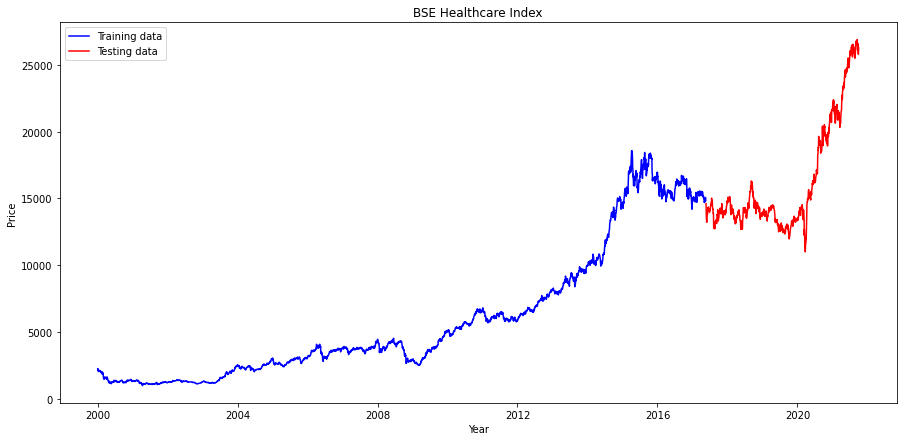

In [8]:
test_size = 0.2
sep_index = int((1 - test_size) * len(ts))
train_ts, test_ts = ts.iloc[: sep_index], ts.iloc[sep_index: ]

ticker_name = "BSE Healthcare"

# plot train and test data
plt.figure(figsize=(15, 7))
plt.title("{} Index".format(ticker_name))
plt.xlabel("Year")
plt.ylabel("Price")
plt.plot(train_ts, color="blue")
plt.plot(test_ts, color="red")
plt.legend(["Training data", "Testing data"])

In [ ]:
train_ts.shape, test_ts.shape

# Training data sanity check

In [ ]:
train_ts.describe()

In [ ]:
train_ts.isnull().sum()

In [ ]:
# probability distribution
plt.figure(figsize=(15, 7))
sns.distplot(train_ts)
plt.title("Probability distribution of '{}' closing price".format(ticker_name))
plt.ylabel("Probability")
plt.xlabel("Close Price")

# Forward chaining cross-validation

In [85]:
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

def score_model(model, data, fit_config=None, test_period=20, plot=False):
    tscv = TimeSeriesSplit(test_size=test_period)
    rmse_scores, mape_scores = [], []
    i = 1
    if plot:
        fig, ax = plt.subplots(figsize=(15, 7))
        ax.set(title="True vs Predicted for all '5' folds in forward chaining CV", xlabel="Day", ylabel="Value")
    for cv_train, cv_test in tscv.split(data):
#         if fit_config:
#             model.fit(data[cv_train], fit_config)
#         else:
#             model.fit(data[cv_train])
        model.fit(data[cv_train], fit_config)
        y_pred = model.predict(len(cv_test)) # TODO
        if plot:
            ax.plot(data[cv_test].index, data[cv_test].values, ".",
                    label="CV {}: train {}, test {} size".format(i, len(cv_train), len(cv_test)))
            ax.plot(data[cv_test].index, y_pred, linewidth=1, linestyle="-.", color="k")
            ax.legend()
        rmse = mean_squared_error(data[cv_test], y_pred, squared=False)
        mape = mean_absolute_percentage_error(data[cv_test], y_pred)
        print("CV {}: RMSE = {:.3f}, MAPE = {:.3f}".format(i, rmse, mape))
        rmse_scores.append(rmse)
        mape_scores.append(mape)
        i += 1
    print("Average scores: RMSE(mean) = {:.3f}, MAPE(mean) = {:.3f}".format(sum(rmse_scores) / len(rmse_scores),
                                                               sum(mape_scores) / len(mape_scores)))

# Baseline Model 1: Latest train value predictor

In [86]:
class LatestPreviousValueBaselineModel:
    def __init__(self):
        self.latest_train_value = -1
    def fit(self, data, fit_config):
        self.latest_train_value = data[-1]
    def predict(self, period=1):
        return pd.Series([self.latest_train_value] * period)

In [87]:
lpv_baseModel = LatestPreviousValueBaselineModel()

CV 1: RMSE = 1162.520, MAPE = 0.413
CV 2: RMSE = 710.388, MAPE = 0.163
CV 3: RMSE = 1386.042, MAPE = 0.271
CV 4: RMSE = 2262.569, MAPE = 0.199
CV 5: RMSE = 5010.966, MAPE = 0.302
Average scores: RMSE(mean) = 2106.497, MAPE(mean) = 0.269


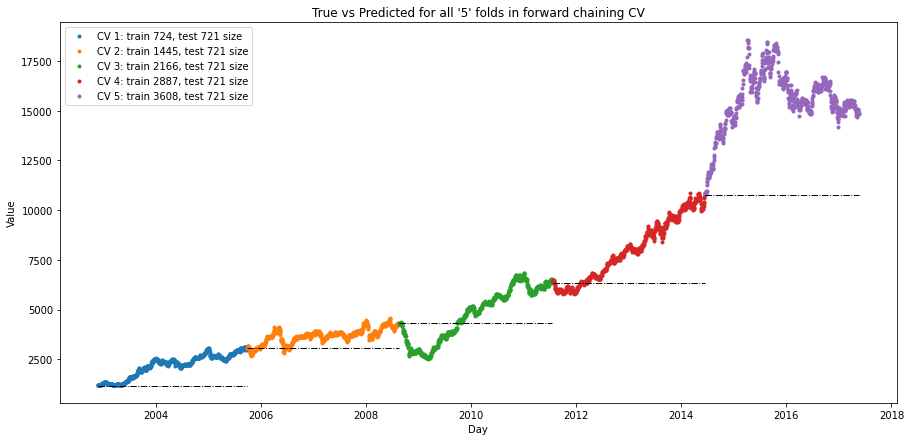

In [88]:
score_model(lpv_baseModel, train_ts, test_period=None, plot=True)

# Baseline Model 2: Simple Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

class LinearRegressionBaselineModel:
    def __init__(self):
        self.model = LinearRegression()
        self.train_end_date = None
    def fit(self, data, fit_config):
        self.train_start_date = data.index[0]
        self.train_end_date = data.index[-1]
        X_train = (data.index - data.index[0]).days.values.reshape(-1, 1)
        y_train = data.values
        self.model.fit(X_train, y_train)
    def predict(self, period=1):
        test_range = pd.date_range(start=self.train_end_date, periods=period + 1)
        X_test = (test_range - self.train_end_date).days.values[1: ].reshape(-1, 1)
        return pd.Series(self.model.predict(X_test))

In [ ]:
lr_baseModel = LinearRegressionBaselineModel()

In [ ]:
score_model(lr_baseModel, train_ts, test_period=None, plot=True)

# SARIMAX
## Box-Jenkins modeling (included)

### Stationarity tests

#### 1. Visual Inspection

In [ ]:
# trend - plotting train data
plt.figure(figsize=(15, 7))
sns.lineplot(data=train_ts)
plt.xlabel("Year")
plt.ylabel("Price")

### # TODO

In [ ]:
# seasonality - plotting year-wise data
yr_groups = train_ts.groupby(pd.Grouper(freq="A"))
yr_wise_df = pd.DataFrame()
for key, yr_group in yr_groups:
    yr_wise_df[key.year] = yr_group.values
yr_wise_df.plot(figsize=(20, 10))
plt.show()

#### 1. Rolling statistics plot

In [ ]:
def get_rolling_statistics(ts, win_size=5, return_data=False):
    roll_mean = ts.rolling(win_size).mean()
    roll_std = ts.rolling(win_size).std()
    fig, ax = plt.subplots(figsize=(15, 7))
    ax.set(title="Rolling Statistics for window size = {}".format(win_size),
           xlabel="Day", ylabel="Value")
    ax.plot(ts, color="red", label="Original data")
    ax.plot(roll_mean, color="black", label="Rolling mean")
    ax.plot(roll_std, color="green", label="Rolling std")
    ax.legend()
    if return_data:
        return roll_mean

In [ ]:
get_rolling_statistics(train_ts)

In [ ]:
get_rolling_statistics(train_ts, win_size=20)

#### 2. Augmented Dicky Fuller Test

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_stationarity_test(ts, max_lag):
    print("Aug Dickey-Fuller test results:-")
    dftest = adfuller(ts, maxlag=max_lag)
    dfoutput = pd.Series(dftest[: 4], index=["ADF statistic", "p-value", "No. of lags used", "No. of obs used"])
    for key, val in dftest[4].items():
        dfoutput["Critical value ({})".format(key)] = val
    print(round(dfoutput, 3))

In [ ]:
adf_stationarity_test(train_ts, max_lag=5*4)

### Stationarizing train data

#### 1. Moving Average method

In [ ]:
moving_avg = get_rolling_statistics(train_ts, win_size=365, return_data=True)

In [ ]:
moving_avg.isna().sum()

In [ ]:
ts_moving_avg_diff = train_ts - moving_avg
ts_moving_avg_diff.head()

In [ ]:
ts_moving_avg_diff.isna().sum()

In [ ]:
ts_moving_avg_diff.dropna(inplace=True)

In [ ]:
get_rolling_statistics(ts_moving_avg_diff)

In [ ]:
adf_stationarity_test(ts_moving_avg_diff, max_lag=5*4)

#### 2. Differencing method

In [42]:
from statsmodels.tsa.statespace.tools import diff

def get_differenced_series(ts, d=1, s=0, return_data=False, plot_original_ts=False):
    diff_ts = diff(ts, k_diff=d, seasonal_periods=s)
    fig, ax = plt.subplots(figsize=(15, 7))
    ax.set(title="Differenced timeseries: d = {}, s(seasonal period) = {}".format(d, s),
           ylabel="Value", xlabel="Day")
    if plot_original_ts:
        ax.plot(ts, label="Original series")
    ax.plot(diff_ts, label="Diff series")
    ax.legend()
    if return_data:
        return diff_ts

In [ ]:
get_differenced_series(train_ts, d=1, plot_original_ts=True)

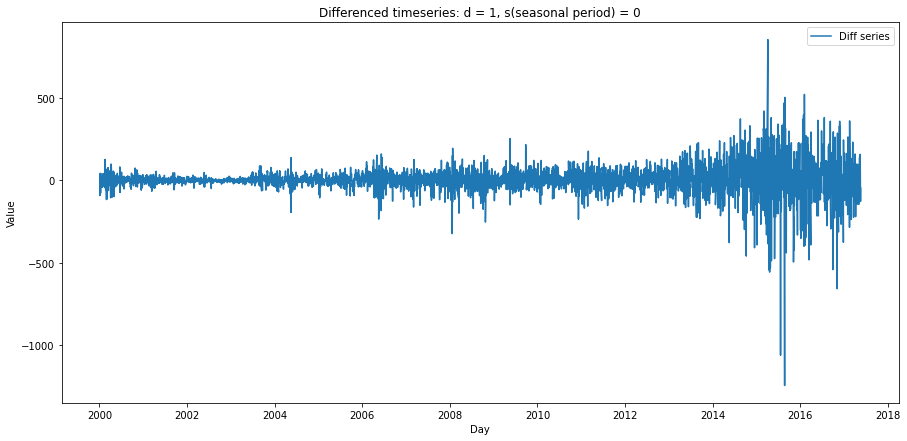

In [43]:
train_ts_diff = get_differenced_series(train_ts, d=1, return_data=True)

In [ ]:
get_differenced_series(train_ts, d=1, s=5)

In [ ]:
 oi                     

In [ ]:
get_rolling_statistics(train_ts_diff)

In [ ]:
adf_stationarity_test(train_ts_diff, max_lag=5*4)

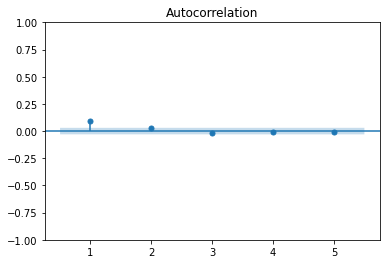

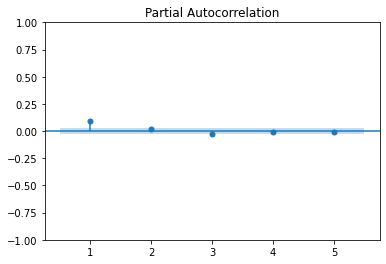

In [46]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf = plot_acf(train_ts_diff, lags=5, zero=False)
pacf = plot_pacf(train_ts_diff, lags=5, zero=False)

#### ARIMA model

In [11]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_ts, order=(2, 1, 1))
res = model.fit()

In [51]:
import statsmodels
print(statsmodels.__version__)

0.13.0


In [ ]:
!pip show statsmodels

In [55]:
train_ts.tail()

Date
2017-05-15    15047.11
2017-05-16    15077.01
2017-05-17    15032.04
2017-05-18    14904.64
2017-05-19    14858.05
Name: Close, dtype: float64

In [38]:
rlt2 = res.get_prediction(start=len(train_ts) - 2)
df = rlt2.summary_frame()
df.head()

Close,mean,mean_se,mean_ci_lower,mean_ci_upper
Date,,,,
2017-05-18,15026.178569,85.419407,14858.759608,15193.597529
2017-05-19,14892.419764,85.419407,14725.000803,15059.838725


In [39]:
rlt2 = res.get_prediction(start=len(train_ts) - 1, end=len(train_ts) - 1)
df = rlt2.summary_frame()
df.head()

Close,mean,mean_se,mean_ci_lower,mean_ci_upper
Date,,,,
2017-05-19,14892.419764,85.419407,14725.000803,15059.838725


In [35]:
train_ts.tail()

Date
2017-05-15    15047.11
2017-05-16    15077.01
2017-05-17    15032.04
2017-05-18    14904.64
2017-05-19    14858.05
Name: Close, dtype: float64

In [16]:
rlt2.predicted_mean

Date
2000-01-03       0.000000
2000-01-04    2247.841389
2000-01-05    2290.157183
2000-01-06    2186.384589
2000-01-07    2180.560726
2000-01-10    2109.323796
Name: predicted_mean, dtype: float64

In [14]:
df = rlt2.summary_frame()

Close,mean,mean_se,mean_ci_lower,mean_ci_upper
Date,,,,
2000-01-03,0.000000,1003.677780,-1967.172300,1967.172300
2000-01-04,2247.841389,85.840471,2079.597158,2416.085619
2000-01-05,2290.157183,85.444772,2122.688506,2457.625859
2000-01-06,2186.384589,85.425782,2018.953133,2353.816044
2000-01-07,2180.560726,85.421009,2013.138624,2347.982828
2000-01-10,2109.323796,85.419810,1941.904045,2276.743546


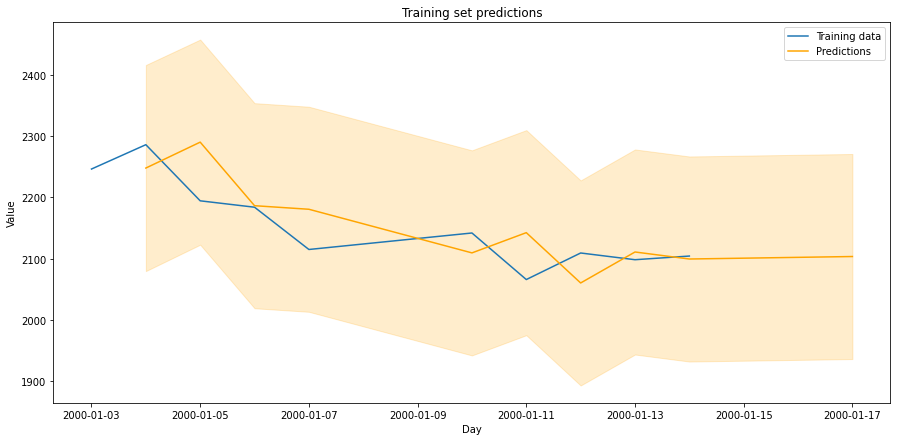

In [29]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.set(title="Training set predictions", xlabel="Day", ylabel="Value")
ax.plot(train_ts[:10], label="Training data")
ax.plot(df["mean"], label="Predictions", color="orange")
ax.fill_between(df.index.values, df["mean_ci_lower"], df["mean_ci_upper"], color="orange", alpha=0.2)
ax.legend()

In [101]:
from statsmodels.tsa.arima.model import ARIMA

class ArimaModel:
    def __init__(self):
        self.model = None
        self.train_size = None
#     def fit(self, data, _order=(0, 0, 0), _seasonal_order=(0, 0, 0, 0),
#             plot_train_performance=False):
#         self.model = ARIMA(data, order=_order, seasonal_order=_seasonal_order)
    def fit(self, data, fit_config, plot_train_performance=False):
        try:
            self.model = ARIMA(data, **fit_config)
            self.model = self.model.fit()
            self.train_size = len(data)
            if plot_train_performance:
                self.__plot_training_performance(data)
        except Exception as ex:
            print(ex)
    def __plot_training_performance(self, data):
        train_results = self.model.get_prediction(start=0, end=len(data) - 1).summary_frame()[1: ]
        rmse = mean_squared_error(data[1: ], train_results["mean"], squared=False)
        mape = mean_absolute_percentage_error(data[1: ], train_results["mean"])
        fig, ax = plt.subplots(figsize=(15, 7))
        ax.set(title="Training set predictions: RMSE = {}, MAPE = {}".format(rmse, mape),
               xlabel="Day", ylabel="Value")
#         ax.plot(data, label="Training data")
        ax.plot(train_results["mean"], label="Predictions", color="orange")
        ax.plot(data, label="Training data")
        ax.fill_between(train_results.index.values, train_results["mean_ci_lower"],
                        train_results["mean_ci_upper"], color="orange", alpha=0.2)
        ax.legend()
    def predict(self, period=1):
        preds = self.model.get_prediction(start=self.train_size, end=self.train_size + period - 1)
        return preds.predicted_mean

In [102]:
arima_model = ArimaModel()

CV 1: RMSE = 1161.523, MAPE = 0.412
CV 2: RMSE = 708.861, MAPE = 0.162
CV 3: RMSE = 1396.598, MAPE = 0.271
CV 4: RMSE = 2269.891, MAPE = 0.200
CV 5: RMSE = 5016.692, MAPE = 0.302
Average scores: RMSE(mean) = 2110.713, MAPE(mean) = 0.269


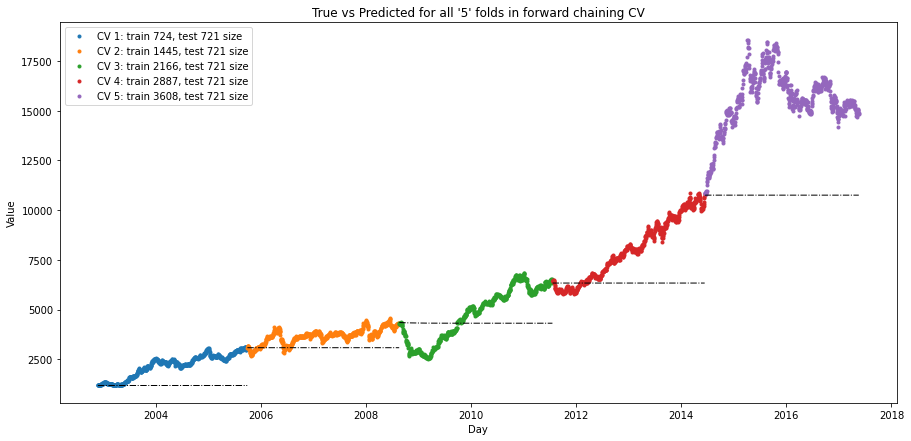

In [100]:
score_model(arima_model, train_ts, fit_config={'order': (2, 1, 2)}, test_period=None, plot=True)

CV 1: RMSE = 1162.520, MAPE = 0.413
CV 2: RMSE = 710.388, MAPE = 0.163
CV 3: RMSE = 1386.042, MAPE = 0.271
CV 4: RMSE = 2262.569, MAPE = 0.199
CV 5: RMSE = 5010.966, MAPE = 0.302
Average scores: RMSE(mean) = 2106.497, MAPE(mean) = 0.269


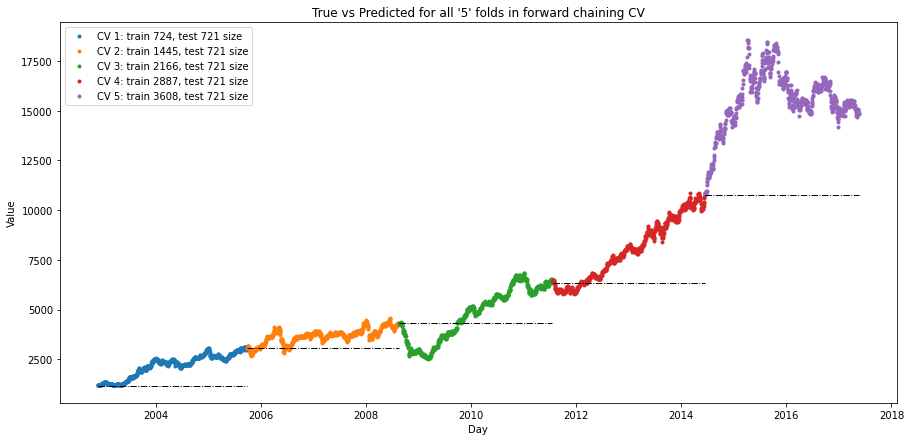

In [91]:
score_model(lpv_baseModel, train_ts, test_period=None, plot=True)

In [99]:
train_ts[: "2014"]

Date
2000-01-03     2246.26
2000-01-04     2285.99
2000-01-05     2194.35
2000-01-06     2183.91
2000-01-07     2114.89
                ...   
2014-12-24    14372.71
2014-12-26    14409.51
2014-12-29    14534.51
2014-12-30    14587.94
2014-12-31    14692.95
Name: Close, Length: 3740, dtype: float64

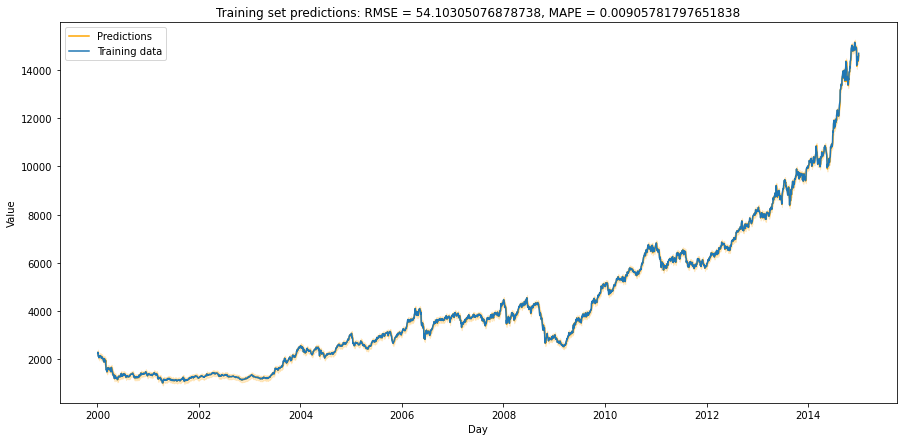

In [103]:
# arima_model.fit(train_ts["2016": ], _order=(2, 1, 2), plot_train_performance=True)
arima_model.fit(train_ts[: "2014"], {'order': (2, 1, 2)}, plot_train_performance=True)

In [ ]:
ax.plot(data[cv_test].index, data[cv_test].values, ".",
                    label="CV {}: train {}, test {} size".format(i, len(cv_train), len(cv_test)))
            ax.plot(data[cv_test].index, y_pred, linewidth=1, linestyle="-.", color="k")
            ax.legend()

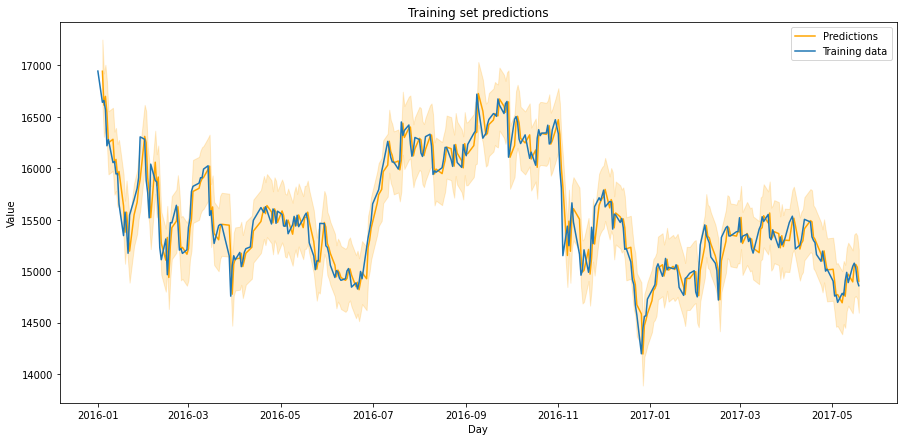

In [75]:
arima_model.fit(train_ts["2016": ], _order=(1, 1, 2), plot_train_performance=True)

In [ ]:
from sklearn.linear_model import LinearRegression

class LinearRegressionBaselineModel:
    def __init__(self):
        self.model = LinearRegression()
        self.train_end_date = None
    def fit(self, data):
        self.train_start_date = data.index[0]
        self.train_end_date = data.index[-1]
        X_train = (data.index - data.index[0]).days.values.reshape(-1, 1)
        y_train = data.values
        self.model.fit(X_train, y_train)
    def predict(self, period=1):
        test_range = pd.date_range(start=self.train_end_date, periods=period + 1)
        X_test = (test_range - self.train_end_date).days.values[1: ].reshape(-1, 1)
        return pd.Series(self.model.predict(X_test))

In [ ]:
rlt = res.forecast(steps=20)

In [ ]:
res.get_predictions(start=0, end=5)

In [ ]:
!pip freeze

In [ ]:
!pip install statsmodels --upgrade

In [ ]:
type(rlt)

In [ ]:
rlt

In [ ]:
train_ts_diff

In [ ]:
res.fittedvalues

In [ ]:
res.summary()

In [ ]:
score_model(lpv_baseModel, train_ts, test_period=None, plot=True)

In [ ]:
train_ts.head()

In [ ]:
round(train_ts.head())

In [ ]:
adftest = adfuller(train_ts, maxlag=4 * 5)

In [ ]:
type(adftest)

In [ ]:
adftest

In [ ]:
# STL decomposition
latest_train_date = train_ts.index[-1]
k = 3
kth_prev_year = latest_train_date.replace(year=latest_train_date.year - k).date()
kth_prev_year.isoformat()

plt.rc("figure", figsize=(15, 7))
stl_decomposition = STL(train_ts[kth_prev_year: ], period=5, robust=True)
res = stl_decomposition.fit()
fig = res.plot()

# ** Rough Work **

In [ ]:
stl_decomposition

In [ ]:
stl_decomposition.config

In [ ]:
stl_decomposition.period

In [ ]:
plt.plot(train_ts.head())

In [ ]:
train_ts.head()

In [ ]:
train_ts.index

In [ ]:
!pip install scikit-learn

In [ ]:
type((train_ts.index - train_ts.index[0]).days.values)

# Baseline model

## 1. Linear Regression

In [ ]:
import numpy as np

In [ ]:
a = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
a

In [ ]:
a[[2, 4]]

In [ ]:
sample = train_ts.head(600)

In [ ]:
sample.shape

In [ ]:
sample.head()

In [ ]:
yr_groups = sample.groupby(pd.Grouper(freq="A"))
yr_wise_df = pd.DataFrame()
for key, yr_group in yr_groups:
#     yr_wise_df[key.year] = yr_group.values
    print(key.year, yr_group.values)
yr_wise_df.plot(figsize=(20, 10))
plt.show()

In [ ]:
groups = sample.groupby(pd.Grouper(freq="A"))

In [ ]:
groups

In [ ]:
groups.describe()

In [ ]:
for key, item in groups:
    print(groups.get_group(key), "\n\n")

In [ ]:
latest_train_date = train_ts.index[-1]
latest_train_date

In [ ]:
date_one_year_earlier.date()

In [ ]:
train_ts[date_one_year_earlier.isoformat():]

In [ ]:
train_ts.iloc[:6].index.dayofweek

In [ ]:
type(plt.rcParams)

In [ ]:
train_ts.last("1A").shape

In [ ]:
datetime.date.today() - pd.DateOffset(years=1)

In [ ]:
train_ts.iloc["2017-":]

In [ ]:
train_ts["2004-01-01": "2007-01-01"].plot(figsize=(12, 6), style=".")

In [ ]:
train_ts["2004-05-01": "2004-09-01"].plot(figsize=(12, 6), style="o")

In [ ]:
ts.iloc[:7]

In [ ]:
train_ts["2004-06-25": "2004-07-05"].plot(figsize=(12, 6), style="o")

In [ ]:
ticker_mapping = {
    "INFY": "BOM500209",
    "TCS": "BOM532540",
    "HCLTECH": "BOM532281",
    "TECHM": "BOM532755"
}
company_list = list(ticker_mapping.keys())
company_list

In [ ]:
!pip install seaborn

In [ ]:
yrs_in_data_window = 2
date_end = datetime.date.today()
# date_start = datetime.date.today() - datetime.timedelta(days=365 * yrs_in_data_window)
date_start = datetime.datetime(date_end.year - 1, date_end.month, date_end.day)
market_data = {}
for nse_ticker, bse_ticker in ticker_mapping.items():
    market_data[nse_ticker] = quandl.get("BSE/" + bse_ticker, start_date=date_start.isoformat(), end_date=date_end.isoformat())

In [ ]:
market_data["INFY"].head()

In [ ]:
market_data["INFY"].shape

In [ ]:
market_data["INFY"].columns

In [ ]:
market_data["INFY"].info()

In [ ]:
market_data["INFY"].describe()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use("default")

In [ ]:
# plot 1 - WAP historical trend
plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=1.25, bottom=1.2)
for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    market_data[company]["WAP"].plot();
    plt.title(company)
    plt.xlabel(None)
    plt.ylabel("WAP")
plt.suptitle("Trend in Weighted Average Price(WAP)")
plt.tight_layout()

In [ ]:
# plot 2 - Volume historical trends
plt.figure(figsize=(15, 7))
for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    market_data[company]["No. of Shares"].plot()
    plt.title(company)
    plt.xlabel(None)
    plt.ylabel("No. of Shares")
plt.suptitle("Volume trends")
plt.tight_layout();

In [ ]:
ticker_mapping = {
    "INFY": "BSE/BOM500209",
    "TCS": "BSE/BOM532540",
    "HCLTECH": "BSE/BOM532281",
    "TECHM": "BSE/BOM532755"
}

In [ ]:
datetime.date.today().isoformat()

In [ ]:
datetime.date.today() - datetime.timedelta(days=365)

In [ ]:
ticker_mapping.items()